# Analyzing 'sit-lie' arrests by LAPD: 2010-19

 Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import geojson
import json
import jenkspy
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

#### Read in arrests data from city portal

In [2]:
# https://data.lacity.org/api/views/yru6-6re4/rows.csv?accessType=DOWNLOAD
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv')

#### How many arrest cases are in the database?

In [3]:
len(arrests)

1297610

#### Clean up arrests DataFrame

In [4]:
arrests.columns = arrests.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], format='%m/%d/%Y')
arrests['year'] = arrests['arrest_date'].dt.year
arrests['day'] = arrests['arrest_date'].dt.day
arrests['month'] = arrests['arrest_date'].dt.month
arrests['monthname'] = arrests['arrest_date'].dt.month_name()
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month', 'day']] = \
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month','day']].astype(str)
arrests['charge_group_code'] = arrests['charge_group_code'].str.replace('.0', '', regex=False)
arrests['weekday'] = arrests['arrest_date'].dt.weekday_name
arrests['time'] = arrests['time'].str.replace('.0','', regex=False)
arrests['time'] = arrests['time'].str.zfill(4)
arrests['hour'] = arrests['time'].str[:2]
arrests['minute'] = arrests['time'].str[2:]
arrests = arrests[arrests['hour'] != '0n']
arrests = arrests[arrests['hour'] != '24']
arrests.drop('cross_street', axis=1, inplace=True)

#### Highlight nighttime hours

In [5]:
night = ['01', '02', '03', '04', '05', '22', '23', '00']
arrests['night'] = arrests['hour'].isin(night)
night_arrests = arrests[arrests['hour'].isin(night)]

In [6]:
len(night_arrests)

336087

#### Separate location field into lat/lon

In [7]:
arrests['location'] = arrests.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in arrests['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

arrests['latitude'] = lat
arrests['longitude'] = lon
arrests['latitude'] = arrests['latitude'].astype(float)
arrests['longitude'] = arrests['longitude'].astype(float)

#### Recode descent names into something useful

In [8]:
descent_recode ={'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian"}

In [9]:
arrests['descent_description'] = arrests['descent_code'].map(descent_recode)

#### Count the arrests by charge type

In [10]:
charges_grouped = arrests.groupby(['charge', 'charge_description']).agg('size').sort_values(ascending=False).reset_index(name='total')

#### Top 10 arrest charges 2010-2019

In [11]:
charges_grouped.head(10)

,charge,charge_description,total
0,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,96828
1,41.27CLAMC,DRINKING IN PUBLIC,93369
2,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,45889
3,11377(A)HS,POSSESSION CONTROLLED SUBSTANCE,40611
4,853.7PC,FTA AFTER WRITTEN PROMISE,31414
5,11350(A)HS,POSSESSION NARCOTIC CONTROLLED SUBSTANCE,29348
6,647(B)PC,PROSTITUTION,26500
7,25620BP,OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE,25884
8,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,25688
9,LAMC,LOS ANGELES MUNICIPAL CODE,24523


#### Isolate all 'sit-lie' cases and just 41.18D

In [12]:
sit_lie_all = arrests[arrests.charge.str.contains('41.18')]
sit_lie_d = arrests[arrests['charge'] == '41.18DLAMC']
sit_lie_test = arrests[arrests.charge.str.contains('4118')]

In [13]:
len(sit_lie_test)

91

In [14]:
# How many 'sit-lie' cases total?
len(sit_lie_all)

36888

In [15]:
# How many '41.18D' cases total?
len(sit_lie_d)

28683

---

#### Descriptives on 'sit-lie' cases

In [16]:
sit_lie_all['sex_code'].value_counts('normalize').round(4)*100

M    74.11
F    25.89
Name: sex_code, dtype: float64

In [17]:
sit_lie_d['year'].value_counts()

2013    4859
2016    4631
2014    4118
2015    4045
2017    3934
2012    3593
2018    1460
2011    1034
2010     750
2019     259
Name: year, dtype: int64

In [18]:
sit_lie_all['descent_description'].value_counts('normalize').round(4)*100

Black                             43.66
White                             33.15
Hispanic                          20.26
Other                              2.37
Asian                              0.54
American Indian/Alaskan Native     0.02
Name: descent_description, dtype: float64

In [19]:
sit_lie_all['night'].value_counts('normalize').round(4)*100

False    95.42
True      4.58
Name: night, dtype: float64

In [20]:
sit_lie_all.head()

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,day,month,monthname,weekday,hour,minute,night,latitude,longitude,descent_description
172,190618578,2019-09-05,1000,6,Hollywood,637,33,M,W,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,1700 TAMARIND AV,"34.103, -118.3196",2019,5,9,September,Thursday,10,00,False,34.1030,-118.3196,White
309,191116167,2019-09-05,1315,11,Northeast,1172,55,M,W,20,Disorderly Conduct,M,41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,SCOTT,"34.0818, -118.2609",2019,5,9,September,Thursday,13,15,False,34.0818,-118.2609,White
392,190122474,2019-09-04,1850,1,Central,156,49,M,B,20,Disorderly Conduct,M,41.18ALAMC,LOITER/OBSTRUCT STREET/SIDEWALK/ETC,6TH,"34.0428, -118.2461",2019,4,9,September,Wednesday,18,50,False,34.0428,-118.2461,Black
419,190122466,2019-09-04,2145,1,Central,192,42,F,O,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,HILL,"34.0377, -118.2621",2019,4,9,September,Wednesday,21,45,False,34.0377,-118.2621,Other
572,190122462,2019-09-03,2045,1,Central,163,41,M,O,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,9TH,"34.043, -118.2571",2019,3,9,September,Tuesday,20,45,False,34.0430,-118.2571,Other


In [21]:
sit_lit_years = sit_lie_all.groupby(['year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')
sit_lit_years.sort_values(by='year', inplace=True)

#### Chart the years

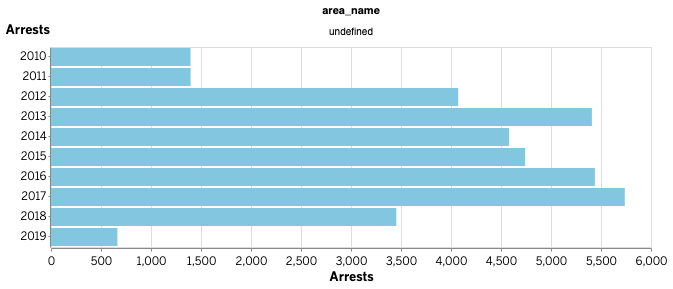

In [22]:
alt.Chart(sit_lit_years).mark_bar().encode(
    y=alt.Y('year:N', title="Arrests", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("total:Q", title="Arrests"),
    facet='area_name:N',
).properties(height=200, width=600)

In [37]:
sit_lit_dates = sit_lie_all.groupby(['month', 'year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')
sit_lit_dates.sort_values(by='year', inplace=True)

In [38]:
sit_lit_dates

,month,year,total
96,10,2010,110
100,3,2010,96
93,8,2010,124
95,11,2010,111
90,4,2010,129
98,9,2010,105
87,6,2010,143
86,7,2010,146
113,2,2010,62
82,5,2010,195


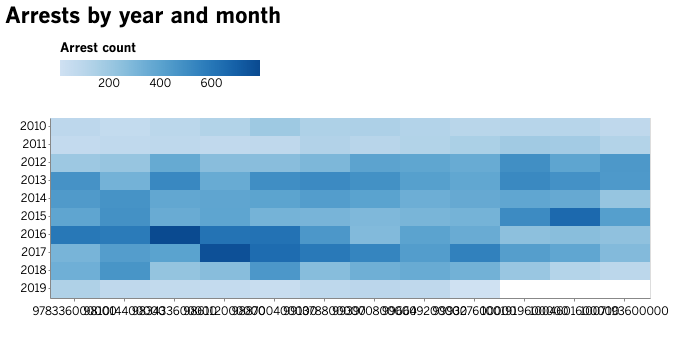

In [44]:
heatmap = alt.Chart(
    sit_lit_dates,
    title="Arrests by year and month"
).mark_rect().encode(
    x=alt.X('month:N', title=' '),
    y=alt.Y('year:N', title=''),
    color=alt.Color('total:Q', title='Arrest count', scale=alt.Scale(scheme="blues")),
    tooltip=[
        alt.Tooltip('month:T', title='Date'),
        alt.Tooltip('total:Q', title='Count')
    ]
#     ,facet=alt.Facet('year(arrest_date):O', title='')
).properties(width=600, height=180,columns=1)

heatmap.configure_legend(
    orient='top',
    padding=10
)

#### Group all 'sit-lie' cases by charge, location, year — and count arrests

In [ ]:
charges_grouped_sit_lie_all = sit_lie_all.groupby(['charge', 'charge_description', 'area_name', 'reporting_district', 'year']).agg('size').sort_values(ascending=False).reset_index()

In [ ]:
charges_grouped_sit_lie_all.columns = ['charge', 'charge_description', 'area_name', 'reporting_district', 'year','total']
charges_grouped_sit_lie_all['reporting_district'] = charges_grouped_sit_lie_all['reporting_district'].astype(str)

In [ ]:
charges_grouped_sit_lie_all.head()

In [ ]:
districts_counts_years_pivot = pd.pivot_table(charges_grouped_sit_lie_all, values='total', index=['reporting_district'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()

districts_counts_years_pivot.head()

---

## Geography

#### Import and clean up LAPD reporting districts

In [ ]:
# convert from shp to geojson
!mapshaper '/Users/mhustiles/data/github/notebooks/arrests/input/LAPD_Reporting_Districts/*.shp'\
-o format=geojson\
'/Users/mhustiles/data/github/notebooks/arrests/output/lapd_reporting_districts.json'

reporting_districts_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/output/lapd_reporting_districts.json')

In [ ]:
reporting_districts_src.plot()

In [ ]:
reporting_districts_src.columns = reporting_districts_src.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

reporting_districts_src = reporting_districts_src.rename(columns={"repdist": "reporting_district"})

In [ ]:
districts = reporting_districts_src[['reporting_district', 'aprec', 'area', 'geometry']]

In [ ]:
districts['reporting_district'] = districts['reporting_district'].astype(str)

---

#### Import and clean up LAPD divisions

In [ ]:
# convert from shp to geojson
!mapshaper '/Users/mhustiles/data/github/notebooks/arrests/input/LAPD_Divisions/LAPD_Divisions.shp'\
-o format=geojson\
'/Users/mhustiles/data/github/notebooks/arrests/output/lapd_divisions.json'

divisions_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/output/lapd_divisions.json')

In [ ]:
divisions_src.plot()

In [ ]:
divisions_src.columns = divisions_src.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
divisions = divisions_src[['aprec', 'prec', 'area', 'geometry']]

#### Import LA Times neighborhoods

In [ ]:
hoodssrc = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/input/custom-la-hoods-skid-row.geojson')

In [ ]:
hoodssrc.columns = hoodssrc.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hoodssrc.plot()

#### Trim the dataframe

In [ ]:
hoods = hoodssrc[['name', 'geometry']]

In [ ]:
hoods.head()

---

## Merge 'sit-lie' arrests data with geography

#### Relate all 'sit-lie' arrests to LA Times neighborhoods

In [ ]:
sit_lie_all_gdf = gpd.GeoDataFrame(sit_lie_all, geometry=gpd.points_from_xy(sit_lie_all.longitude, sit_lie_all.latitude))

In [ ]:
sit_lie_all_gdf.crs = {'init': "epsg:4326"}

In [ ]:
sit_lie_all_hoods = gpd.sjoin(sit_lie_all_gdf, hoods, op='within', how="inner")

#### 'Busy' neighborhoods: Skid Row, elsewhere Downtown, Venice, Hollywood

In [ ]:
busy_hoods = ['Skid Row', 'Downtown', 'Venice', 'Hollywood']

In [ ]:
sit_lie_all_hoods['busy'] = sit_lie_all_hoods['name'].isin(busy_hoods)

In [ ]:
sit_lie_all_hoods.iloc[10]

In [ ]:
sit_lie_all_hoods_slim = sit_lie_all_hoods[['report_id','arrest_date','time','area_id','area_name','reporting_district','age','sex_code','descent_code','charge_group_code','charge_group_description','arrest_type_code','charge','charge_description','year','month','weekday','name', 'busy']]

In [ ]:
sit_lie_all_hoods_slim.head()
len(sit_lie_all_hoods_slim)

#### Totals by neighborhood

In [ ]:
hood_counts = sit_lie_all_hoods_slim.groupby(['name']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
#Large neighborhoods
hood_counts_busy = hood_counts[hood_counts['total'] > 200 ].sort_values(by='total', ascending=False)

In [ ]:
hood_counts['total'].sum()

In [ ]:
hood_counts['share'] = ((hood_counts['total'] / hood_counts['total'].sum())*100).round()
hood_counts.head()

In [ ]:
bars = alt.Chart(hood_counts_busy).mark_bar().encode(
    x=alt.X('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6)), 
    y=alt.Y(
        'name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            order="descending"  # The order to sort in
        )
    )
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='total:Q'
)
(bars + text).properties(height=500, width=400)

In [ ]:
hood_counts_years = sit_lie_all_hoods_slim.groupby(['name', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
hood_counts_years.head()

#### What's the share of the arrests in the 'busy' neighborhoods: Skid row, elsewhere Downtown, Venice, Hollywood?

In [ ]:
hood_counts_years_grouped = sit_lie_all_hoods_slim.groupby(['year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
alt.Chart(hood_counts_years_grouped).mark_bar().encode(
    x=alt.X('total', axis=alt.Axis(tickCount=6)),
    y='year',
    color='busy'
)

#### Pivot on year and neighborhood

In [ ]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, values='total', index=['name'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()
hood_counts_years_pivot.head(10)

#### Filter neighborhoods to the busiest: Skid Row, elsewhere downtown, Hollywood and Venice

In [ ]:
hood_counts_years_busy = hood_counts_years[hood_counts_years['busy'] == True]

In [ ]:
hood_counts_years_busy.head()

#### Arrests by year in Downtown, Hollywood and Venice

In [ ]:
alt.Chart(hood_counts_years_busy).mark_bar().encode(
    y=alt.Y('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6),
        sort=alt.EncodingSortField(
            field="year",  # The field to use for the sort
            order="ascending"  # The order to sort in
        )), 
    x=alt.X(
        'year:N', axis=alt.Axis(format='', title='Year')
    ),
    facet='name:O').properties(
    columns=2,
    width=350,
    height=250
)

---

#### Merge districts with pivoted arrest totals

In [ ]:
districts_counts_years_pivot_geo = districts.merge(districts_counts_years_pivot, on='reporting_district').sort_values(by='2019', ascending=False)

In [ ]:
districts_counts_years_pivot_geo.head()

In [ ]:
districts_sit_lie_grouped_geo = districts.merge(charges_grouped_sit_lie_all, on='reporting_district').sort_values(by='year', ascending=False)

In [ ]:
districts_sit_lie_grouped_geo.head()

#### Export to GeoJSON

In [ ]:
districts_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/districts_counts_years_pivot_geo.json', driver='GeoJSON')

---

## Mapping

In [ ]:
breaks = jenkspy.jenks_breaks(list(districts_sit_lie_grouped_geo.total), nb_class=5)
breaks

In [ ]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [ ]:
districts_sit_lie_grouped_geo['arrest_group'] = districts_sit_lie_grouped_geo.total.apply(get_group)

In [ ]:
districts_sit_lie_grouped_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/districts_sit_lie_grouped_geo.json', driver='GeoJSON')

In [ ]:
districts_sit_lie_grouped_geo.head()

In [ ]:
sit_lie_geojson = json.loads(districts_sit_lie_grouped_geo.to_json())
sit_lie_features = alt.Data(values=sit_lie_geojson['features'])

In [ ]:
districts_geojson = json.loads(districts.to_json())
districts_features = alt.Data(values=districts_geojson['features'])

In [ ]:
hoods_geojson = json.loads(hoods.to_json())
hoods_features = alt.Data(values=hoods_geojson['features'])

In [ ]:
districts_geojson_pivot = json.loads(districts_counts_years_pivot_geo.to_json())
districts_geojson_pivot_features = alt.Data(values=districts_geojson_pivot['features'])

In [ ]:
basemap = alt.Chart(districts_features).mark_geoshape(
    fill='lightgray',
    stroke=''
).project('mercator')

groups = alt.Chart(sit_lie_features).mark_geoshape(
    stroke='white'
).encode(
    color='properties.arrest_group:Q'
).transform_filter(
    alt.FieldEqualPredicate(field='properties.year', equal='2016')
)

hoodsmaps = alt.Chart(hoods_features).mark_geoshape(
    fill='',
    stroke='#999999',
    strokeWidth=.2
)

(basemap+groups+hoodsmaps).properties(
    width=600,
    height=600
)

In [ ]:
variable_list = ['properties.2010','properties.2011','properties.2012','properties.2013','properties.2014','properties.2015','properties.2016','properties.2017','properties.2018','properties.2019']

In [ ]:
alt.Chart(districts_features).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='properties.reporting_district',
    from_=alt.LookupData(districts_geojson_pivot_features, 'properties.reporting_district', variable_list)
).properties(
    width=500,
    height=500
).repeat(
    row=variable_list
).resolve_scale(
    color='shared'
)

#### Group all 'sit-lie' cases by place and time

In [ ]:
time_sit_lie_hoods = sit_lie_all_hoods.groupby(['name', 'year', 'hour', 'night']).agg('size').sort_values(ascending=False).reset_index()

In [ ]:
time_sit_lie_hoods.columns = ['name', 'year','hour', 'night', 'total']

In [ ]:
time_sit_lie_hoods.head()

In [ ]:
time_sit_lie_hoods_busy = time_sit_lie_hoods[time_sit_lie_hoods['name'].isin(busy_hoods)]

In [ ]:
alt.Chart(time_sit_lie_hoods).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.night == True,
        alt.value('orange'), 
        alt.value('#82c6df')
    )
).properties(
    title='\'Sit-lie\' arrests in all neighborhoods, by hour',
    columns=2,
    width=320,
    height=300
)

In [ ]:
alt.Chart(time_sit_lie_hoods_busy).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='Arrests by hour and busy neighborhood w/ 6-7a.m. highlighted',
    columns=2,
    width=320,
    height=200
)

#### How many 'sit-lit' arrests happen between 9-6 a.m.?

In [ ]:
time_sit_lie_hoods_busy['night'].value_counts('normalize').round(2)

In [ ]:
time_sit_lie_hoods_busy_grouped = time_sit_lie_hoods_busy.groupby(['year', 'night']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
time_sit_lie_hoods_busy_grouped.head()

In [ ]:
alt.Chart(time_sit_lie_hoods_busy_grouped).mark_bar().encode(
    x=alt.X('total:Q', stack="normalize", axis=alt.Axis(format='%',tickCount=6)),
    y='year:N',
    color='night'
)

#### What is the average number of arrests per month — and how has that changed over the years? 

In [ ]:
sit_lie_all_hoods.columns

#### Groupby neighborhood and dates — all hoods

In [ ]:
months_grouped = sit_lie_all_hoods.groupby(['name', 'monthname', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

#### Groupby neighborhood and dates — busy hoods

In [ ]:
months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['busy'] == True].groupby(['name', 'monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
alt.Chart(months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='A decade of arrests by month and busy neighborhood',
    columns=2,
    width=320,
    height=200
)

#### What's going on in Skid Row?

In [ ]:
skidrow_months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['name'] == 'Skid Row'].groupby(['name', 'year','monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
alt.Chart(skidrow_months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='year:O'
).properties(
    title='Monthly arrests in skid row by year',
    columns=5,
    width=150,
    height=200
)

#### Arrests by day

In [ ]:
arrest_dates = arrests.groupby(['arrest_date', 'year', 'weekday']).agg('size').reset_index(name='total')

In [ ]:
alt.Chart(arrest_dates).mark_bar().encode(
    x=alt.X('arrest_date:T', axis=alt.Axis(format='%Y', title='', tickCount = 10)),
    y=alt.X('total:Q', axis=alt.Axis(format='', title='', tickCount = 10)),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.arrest_date == '2018-09-04',  # If the year is 1810 this test returns True,
        alt.value('#000000'),     # which sets the bar orange.
        alt.value('skyblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(title='Sit-lie arrests by day', width=800)


In [ ]:
alt.Chart(arrest_dates).mark_bar().encode(
    x=alt.X('weekday:O', axis=alt.Axis(title='', tickCount = 10), 
            sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y=alt.X('total:Q', axis=alt.Axis(title='', tickCount = 10)
),
    facet='year:O'
).properties(
    title='Arrests by day of the week and year',
    columns=2,
    width=300,
    height=200
)

---

## Homeless population estimates by LA Times neighborhoods

In [ ]:
homelessbyhood = pd.read_csv('input/homeless-unsheltered-by-hood.csv')

In [ ]:
homelessbyhood

#### Merge with previously pivoted arrests data with hoods spatial data — then merge population counts

In [ ]:
hood_counts_years

In [ ]:
hoods_counts_years_pivot_geo = hoods.merge(hood_counts_years_pivot, on='name').sort_values(by='2019', ascending=False)

In [ ]:
hoods_homeless_counts_years_pivot_geo = hoods_counts_years_pivot_geo.merge(homelessbyhood, on='name').sort_values(by='2019', ascending=False)

In [ ]:
hoods_homeless_counts_years_pivot_geo.head()

#### Loop and create rate columns for each year

In [ ]:
# hoods_homeless_counts_years_pivot_geo['2017-rate'] = (hoods_homeless_counts_years_pivot_geo['2017']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100

for n in range(2010, 2020):
    hoods_homeless_counts_years_pivot_geo[f'{n}_rate'] =(hoods_homeless_counts_years_pivot_geo[f'{n}']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100


In [ ]:
hoods_homeless_counts_years_pivot_geo.head()

#### Export GeoJSON

In [ ]:
hoods_homeless_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/hoods_homeless_counts_years_pivot_geo.json', driver='GeoJSON')

In [ ]:
hoods_homeless_counts_years_pivot_geo.to_csv('/Users/mhustiles/data/github/notebooks/arrests/output/hoods_homeless_counts_years_pivot_geo.csv')

In [ ]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, values='total', index=['name'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()
